In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Load an image

In [2]:
run=105
rootdir = '/cds/home/i/igabalsk/TRXS-Run18/Template-Notebooks/'
path = rootdir + 'CSPADsummed-run-195.npy'
data = np.load(path)

# Load an image from PSANA

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import psana

import os
import sys

experiment='cxilu9218'
run=195

# Create a data source to grab data from
ds = psana.DataSource('exp=%s:run=%d:smd' % (experiment , run) )

data = None
nsum = 0
# Iterate through events
nevent = 0
evr = psana.Detector('evr1')
jf = psana.Detector('jungfrau4M')
for evt in ds.events():
    nevent+=1
    jfimg = jf.calib(evt,mbits=39)
    if jfimg is not None:
        jfimg[jfimg<350.] = 0.
        if data is None:
            data = jfimg
            nsum = 1
        else:
            data += jfimg
            nsum += 1
    if nevent==1000: break
print('Processed',nevent,'events.')
data = data/float(nsum)

('Processed', 1000, 'events.')


## Get x and y coordinates

In [25]:
# This is a little bit dirty, randomly using some of Matt's functions to get something 
# I could also do directly from the xtc files...
import sys
import os
experiment='cxilu9218'
runNumber=run
# Set the installation and output path
os.environ['INSTALLPATH']= '/cds/home/t/tw2809/X402'
os.environ['OUTPUTPATH']= '/cds/data/psdm/%s/%s/scratch' % (experiment[0:3],experiment)
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from dataAnalysis import *

x,y = CSPADgeometry(detType='Jungfrau', run=runNumber, experiment=experiment)

## Plot raw image

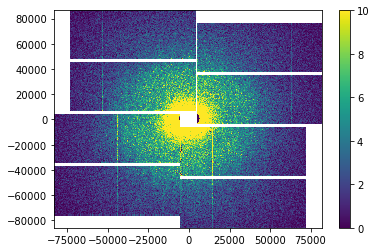

In [26]:
# %matplotlib notebook # Might need to be replaced by "%matplotlib inline" jupyterlab

plt.figure()
for i in np.arange(8):
    plt.pcolormesh(x[i],y[i],data[i,:,:],vmin=0,vmax=1e1) # Color scale limits might need adjustment
plt.colorbar()

## Mask off horizontal and vertical stripes

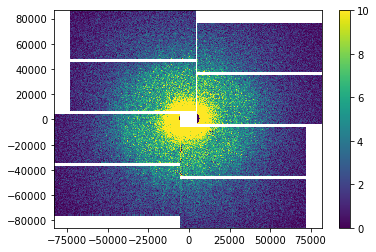

In [27]:
mask = np.ones_like(data)
mask[:,255:257,:] = np.nan
mask[:,0:2,:] = np.nan
mask[:,511,:] = np.nan
mask[:,:,0] = np.nan
mask[:,:,255:257] = np.nan
mask[:,:,511:513] = np.nan
mask[:,:,767:769] = np.nan
mask[:,:,1023] = np.nan

plt.figure()
for i in np.arange(8):
    plt.pcolormesh(x[i],y[i],(data*mask)[i,:,:],vmin=0,vmax=1e1)
plt.colorbar()

## Find center of diffraction pattern

In [28]:
from scipy.ndimage import gaussian_filter
from scipy import optimize

class circfit(object):
    """
    This class fits a circle into a bunch of points.
    """
    def __init__(self,x,y):
        """
         Arguments:
        x: x-coordinates of input points
        y: y-coordinates of input points
        """
        self.x = x
        self.y = y
    
    def fit(self):
        """
        Returns:
        xc_2, yc_2: x,y coordinates of fitted center
        """
        x_m = np.mean(self.x)
        y_m = np.mean(self.y)
        center_estimate = x_m, y_m
        center_2, ier = optimize.leastsq(self.f_2, center_estimate)
        
        xc_2, yc_2 = center_2
        Ri_2 = self.calc_R(*center_2)
        R_2 = Ri_2.mean()
        residu_2 = np.square(Ri_2-R_2).sum()
        return xc_2,yc_2
    
    def calc_R(self,xc,yc):
        return np.sqrt(np.square(self.x-xc)+np.square(self.y-yc))
    
    def f_2(self,c):
        Ri = self.calc_R(*c)
        return Ri - Ri.mean()
    

    
def find_center(x,y,img,lbound,ubound):
    """
    Function to fit a center into a diffraction pattern by determining points of similar intensity
    and fitting a ring into these points. The results are being plotted.
    Arguments:
    x,y: x,y coordinates of the diffraction pattern
    img: Diffraction pattern
    lbound: lower limit of the intensity range in which points are being identified for the circle fitting
    ubound: upper limit of the intenisty range
    Returns:
    cx,cy: x,y coordinates of the center of the fitted circle
    [allx,ally]: x,y coordinates of all points in the chosen intensity range
    """
    plt.figure()
    for i in np.arange(8):
        tile = gaussian_filter(img[i,:,:],(1,1))
        inds = np.where((tile>lbound)&(tile<ubound))
        plt.plot(x[i][inds[0],inds[1]],y[i][inds[0],inds[1]],'.',color='yellow')
        plt.pcolormesh(x[i],y[i],tile,vmin=0,vmax=5e1)
        if i==0:
            allx = x[i][inds[0],inds[1]]
            ally = y[i][inds[0],inds[1]]
        else:
            allx = np.concatenate((allx,x[i][inds[0],inds[1]]))
            ally = np.concatenate((ally,y[i][inds[0],inds[1]]))
        
        
    centerfit = circfit(allx,ally)
    cx,cy = centerfit.fit()
    plt.plot([cx],[cy],'.',markersize=10, label='Fitted center')
    #plt.legend(loc='best')
    return cx,cy, [allx,ally]
 

/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in greater
/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in less


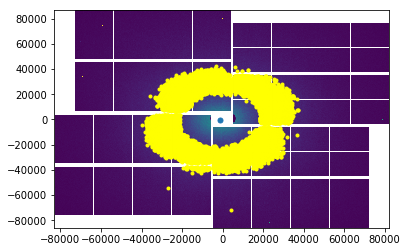

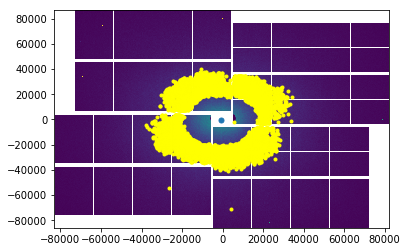

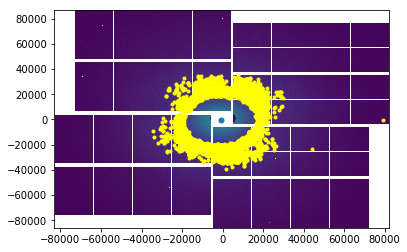

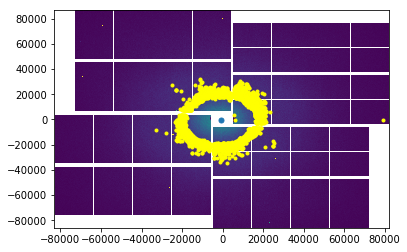

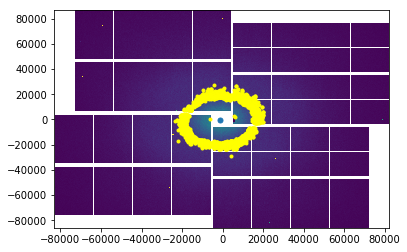

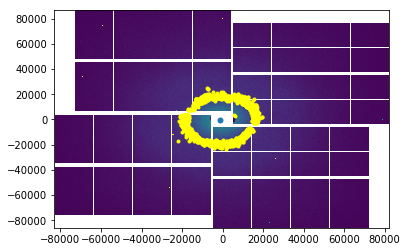

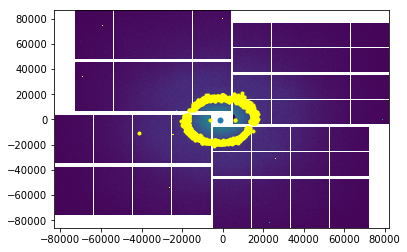

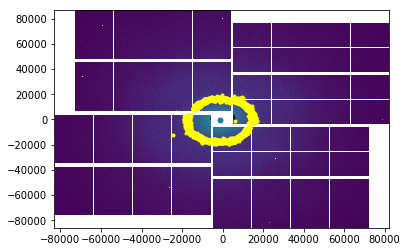

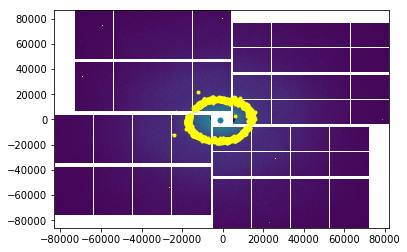

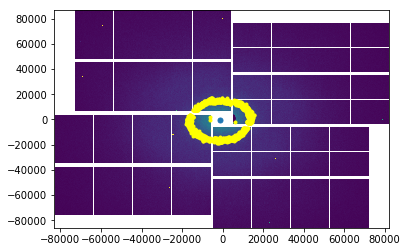

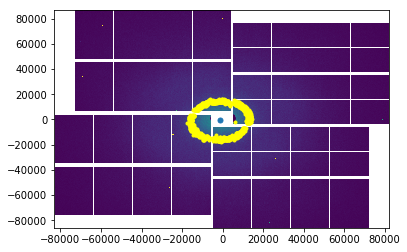

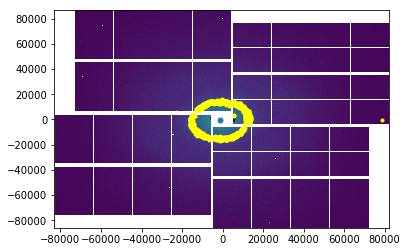

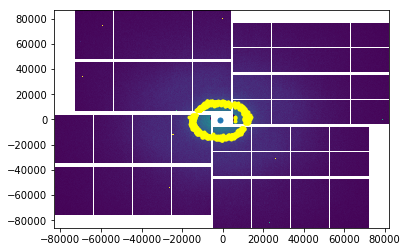

In [29]:
# The center is fitted here for a number of intensity ranges.

#Intensity ranges of the points for the center fitting, might need to be adjusted.
lbounds = np.arange(6,12.5,0.5)
ubounds = lbounds + 0.1

xcenters = np.zeros_like(lbounds)
ycenters = np.zeros_like(lbounds)
for i in np.arange(len(lbounds)):
    xcenter,ycenter,inds = find_center(x,y,(data*mask),lbounds[i],ubounds[i])
    xcenters[i] = xcenter
    ycenters[i] = ycenter

Text(0.5,1,'Dependence of fitted diffraction center on pixel intensity for ring-fitting')

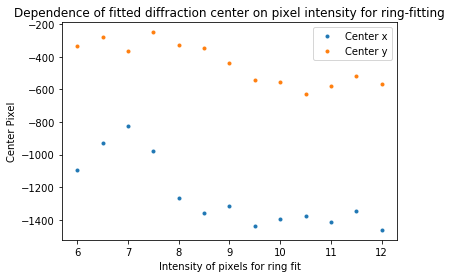

In [30]:
# Plot intensity range dependence of diffraction center:
plt.figure()
plt.plot(lbounds,xcenters,'.',label='Center x')
plt.plot(lbounds,ycenters,'.',label='Center y')
plt.xlabel('Intensity of pixels for ring fit')
plt.ylabel('Center Pixel')
plt.legend(loc='best')
plt.title('Dependence of fitted diffraction center on pixel intensity for ring-fitting')

## Azimuthally average the diffraction pattern

In [31]:
def make_radav(cent,img,x,y,binsize=100):
    """
    Function to azimuthally average and rebin a diffraction pattern
    Arguments:
    cent: list with x and y coordinates of the diffraction center
    img: diffraction pattern
    x,y: x and y coordinates of diffraction pattern
    binsize: Size of the bins
    Returns:
    patt: Azimuthally averaged and rebinned diffraction pattern
    """
    # Initialize parameters, radial map and diffraction pattern array:
    xcent = cent[0]
    ycent = cent[1]
    rmap = np.sqrt(np.square(x-xcent)+np.square(y-ycent)).round()
    rmin = rmap.min()
    rmax = rmap.max()
    rbins = np.arange(rmin,rmax+binsize,binsize)
    patt = np.zeros((len(rbins),))
    # Find all pixel within a radial bin, remove outliers and determine the average intensity value
    for i in np.arange(len(rbins)-1):
        inds = np.where((rmap>=rbins[i])&(rmap<rbins[i+1]))
        ring = img[inds]
        meanring = np.nanmean(ring)
        stdring = np.nanstd(ring)
        # Remove outliers
        inds = np.where(abs(ring-meanring)<=3*stdring)
        patt[i] = np.nanmean(ring[inds])
    return patt

In [32]:
# Use the mean of the centers from the 5 highest intensity ranges as center and azimuthally average the diffraction pattern:
xcenter = np.mean(xcenters[-5:])
ycenter = np.mean(ycenters[-5:])
patt = make_radav([xcenter,ycenter],data,x,y)
print(xcenter,ycenter)

(-1398.5332786367896, -569.900927931394)


Text(0.5,0,' Q / a.u.')

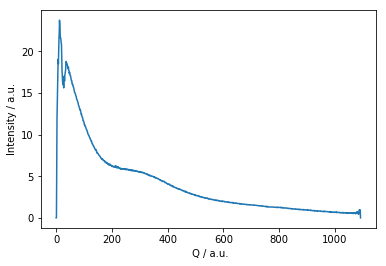

In [33]:
plt.figure()
plt.plot(patt)
plt.ylabel('Intensity / a.u.')
plt.xlabel(' Q / a.u.')